In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import datetime
%matplotlib inline
import wandb

### Step 0. Loading dataset

In [4]:
run = wandb.init()
artifact = run.use_artifact('ytdteam/ytd-cassandra-forecast/meta-stock-price:v0', type='raw_data')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: salih-atabey (ytdteam). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [5]:
stock = pd.read_csv('artifacts/meta-stock-price-v0/meta.us.txt')
stock.columns = ['TICKER','PER','DATE','TIME','OPEN','HIGH','LOW','CLOSE','VOL','OPENINT']
stock['TIME'] = pd.to_datetime(stock['TIME'],format='%H%M%S').dt.time
stock['DATE'] = pd.to_datetime(stock['DATE'],format='%Y%m%d').dt.date

In [6]:

print(stock.isnull().sum())                     
stock.groupby(by=["TIME"]).count()
stock = stock[(stock.TIME!=datetime.time(15,0,0))]
stock['Date-time'] = pd.to_datetime(stock.DATE.astype(str) + ' ' + stock.TIME.astype(str))
stock=stock.set_index(pd.DatetimeIndex(stock['Date-time'].values))
stock.head()                        

TICKER     0
PER        0
DATE       0
TIME       0
OPEN       0
HIGH       0
LOW        0
CLOSE      0
VOL        0
OPENINT    0
dtype: int64


,TICKER,PER,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,OPENINT,Date-time
2021-12-30 16:00:00,META.US,60,2021-12-30,16:00:00,344.00,345.700,343.22,345.275,1227974,0,2021-12-30 16:00:00
2021-12-30 17:00:00,META.US,60,2021-12-30,17:00:00,345.29,346.570,344.75,344.750,1365663,0,2021-12-30 17:00:00
2021-12-30 18:00:00,META.US,60,2021-12-30,18:00:00,344.80,345.383,344.17,345.366,755072,0,2021-12-30 18:00:00
2021-12-30 19:00:00,META.US,60,2021-12-30,19:00:00,345.37,345.900,345.13,345.493,544627,0,2021-12-30 19:00:00
2021-12-30 20:00:00,META.US,60,2021-12-30,20:00:00,345.49,346.696,345.28,346.535,565582,0,2021-12-30 20:00:00


In [7]:
data_to_use = stock['CLOSE'].values

In [8]:
print('Total number of data points in the dataset: {}'.format(len(data_to_use)))

Total number of data points in the dataset: 1446


### Step 1. Data preprocessing

#### Step 1.1 Scaling data

In [9]:
scaler = StandardScaler()

In [10]:
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))

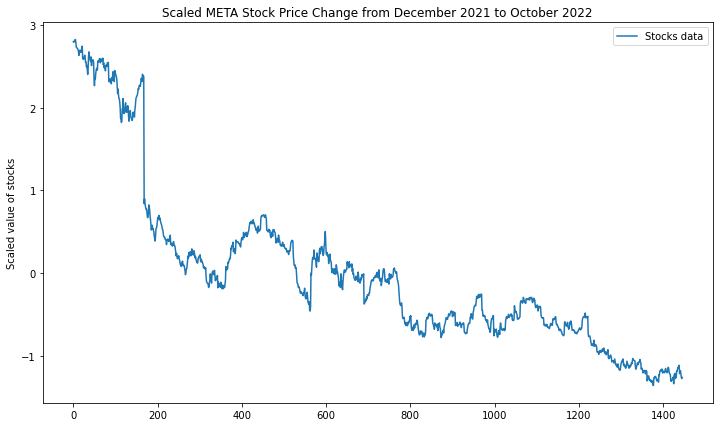

In [11]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled META Stock Price Change from December 2021 to October 2022')
plt.ylabel('Scaled value of stocks')
plt.plot(scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

In [12]:
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

#### Step 1.2 Windowing the dataset

In [13]:
X, y = window_data(scaled_dataset, 1)

#### Step 1.3 Creating Train and Test sets

In [14]:
X_train  = np.array(X[:1155])
y_train = np.array(y[:1155])

X_test = np.array(X[1155:])
y_test = np.array(y[1155:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1155, 1, 1)
y_train size: (1155, 1)
X_test size: (290, 1, 1)
y_test size: (290, 1)


### Metrics

In [15]:
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                   
    return rmse

In [16]:
def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

### Let's create the RNN

In [17]:
def LSTM_cell(hidden_layer_size, batch_size,number_of_layers, dropout=True, dropout_rate=0.8):
    
    layer = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(hidden_layer_size)
    
    if dropout:
        layer = tf.compat.v1.nn.rnn_cell.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        
    cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([layer]*number_of_layers)
    
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

In [18]:
def output_layer(lstm_output, in_size, out_size):
    
    x = lstm_output[:, -1, :]
    print(x)
    weights = tf.Variable(tf.compat.v1.random.truncated_normal([in_size, out_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    
    output = tf.matmul(x, weights) + bias
    return output

In [19]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin, batch_size):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))])
        
    loss = tf.reduce_sum(losses)/(2*batch_size)
    
    #Cliping the gradient loss
    gradients = tf.gradients(loss, tf.compat.v1.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.optimizers.Adam(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.compat.v1.trainable_variables()))
    return loss, train_optimizer

In [20]:
class StockPredictionRNN(object):
    
    def __init__(self, learning_rate=0.0005, batch_size=2, hidden_layer_size=512, number_of_layers=1, 
                 dropout=True, dropout_rate=0.8, number_of_classes=1, gradient_clip_margin=4, window_size=1):
    
        tf.compat.v1.disable_eager_execution()
        self.inputs = tf.compat.v1.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
        self.targets = tf.compat.v1.placeholder(tf.float32, [batch_size, 1], name='targets')

        cell, init_state = LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout, dropout_rate)

        outputs, states = tf.compat.v1.nn.dynamic_rnn(cell, self.inputs, initial_state=init_state)

        self.logits = output_layer(outputs, hidden_layer_size, number_of_classes)

        self.loss, self.opt = opt_loss(self.logits, self.targets, learning_rate, gradient_clip_margin, batch_size)

### Weight and Biases Experiments

In [21]:
sweep_config = {
    'method': 'random',
    'metric': {'goal': 'minimize', 'name': 'mape'},
    'parameters': {
        'batch_size': {'value': 2},
        'dropout_rate': {'values': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]},
        'epochs': {'values': [30, 40, 50, 60, 70, 80]},
        'learning_rate': {
            'distribution': 'uniform',
            'max': 0.0010,
            'min': 0
        },
    }
}

In [22]:
sweep_id = wandb.sweep(sweep_config, project="tensorflow-lstm-sweep", entity="ytdteam")

Create sweep with ID: uosa5sx3
Sweep URL: https://wandb.ai/ytdteam/tensorflow-lstm-sweep/sweeps/uosa5sx3


In [23]:
def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        tf.compat.v1.reset_default_graph()
        model = StockPredictionRNN(
            learning_rate = config.learning_rate,
            batch_size = config.batch_size,
            dropout_rate = config.dropout_rate,
        )
        session = tf.compat.v1.Session()
        session.run(tf.compat.v1.global_variables_initializer())

        for i in range(config.epochs):
            traind_scores = []
            ii = 0
            epoch_loss = []
            while(ii + config.batch_size) <= len(X_train):
                X_batch = X_train[ii:ii+config.batch_size]
                y_batch = y_train[ii:ii+config.batch_size]
                
                o, c, _ = session.run([model.logits, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})
                
                epoch_loss.append(c)
                traind_scores.append(o)
                ii += config.batch_size
            print('Epoch {}/{}'.format(i, config.epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
        # Evaluate
        sup =[]
        for ii in range(len(traind_scores)):
            for jj in range(len(traind_scores[ii])):
                sup.append(traind_scores[ii][jj])
        tests = []
        ii = 0
        while ii+config.batch_size <= len(X_test):                
            o = session.run([model.logits], feed_dict={model.inputs:X_test[ii:ii+config.batch_size]})
            ii += config.batch_size
            tests.append(o)
        tests_new = []
        for ii in range(len(tests)):
            for jj in range(len(tests[ii][0])):
                tests_new.append(tests[ii][0][jj])
        test_results = []
        for ii in range(1446):
            if ii >= 1156:
                test_results.append(tests_new[ii-1156])
            else:
                test_results.append(None)
        # Plot
        fig = plt.figure(figsize=(16, 7))
        plt.plot(scaled_dataset, label='Original data')
        plt.plot(sup, label='Training data')
        plt.plot(test_results, label='Testing data')
        plt.legend()
        plt.show()
        plt.close()
        # Metrics
        y_true = np.array(scaled_dataset[1158:1446])
        y_pred = np.array(test_results[1158:1446])
        mape_lstm = calculate_mape(y_true, y_pred)
        rmse_lstm = calculate_rmse(scaler.inverse_transform(y_true), scaler.inverse_transform(y_pred))
        # Wandb
        wandb.log({"loss": sum(epoch_loss)/len(epoch_loss), "mape": mape_lstm, "rmse": rmse_lstm, "plot": wandb.Image(fig)})
        session.close()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: y05gli6k with config:
wandb: 	batch_size: 2
wandb: 	dropout_rate: 0.8
wandb: 	epochs: 70
wandb: 	learning_rate: 0.0007220720796514879
Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\envs\default\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "D:\ProgramData\Anaconda3\envs\default\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "D:\ProgramData\Anaconda3\envs\default\lib\site-packages\wandb\sdk\wandb_run.py", line 200, in check_status
    status_response = self._interface.communicate_stop_status()
  File "D:\ProgramData\Anaconda3\envs\default\lib\site-packages\wandb\sdk\interface\interface.py", line 128, in communicate_stop_status
    resp = self._communicate_stop_status(status)
  File "D:\ProgramData\Anaconda3\envs\default\lib\site-packages\wandb\sdk\interface\interface_sock.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


D:\ProgramData\Anaconda3\envs\default\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:708: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
D:\ProgramData\Anaconda3\envs\default\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Tensor("strided_slice:0", shape=(2, 512), dtype=float32)
Epoch 0/70  Current loss: 0.21249057352542877
Epoch 1/70  Current loss: 0.008887223899364471
Epoch 2/70  Current loss: 0.0029468275606632233
Epoch 3/70  Current loss: 0.0030804742127656937
Epoch 4/70  Current loss: 0.0029733162373304367
Epoch 5/70  Current loss: 0.0029617627151310444
Epoch 6/70  Current loss: 0.0031224058475345373
Epoch 7/70  Current loss: 0.0029618400149047375
Epoch 8/70  Current loss: 0.0032004625536501408
Epoch 9/70  Current loss: 0.0031892971601337194
Epoch 10/70  Current loss: 0.0034665726125240326
Epoch 11/70  Current loss: 0.0033971210941672325
Epoch 12/70  Current loss: 0.0035496798809617758
Epoch 13/70  Current loss: 0.003190102521330118
Epoch 14/70  Current loss: 0.0033683425281196833
Epoch 15/70  Current loss: 0.0035058031789958477
Epoch 16/70  Current loss: 0.0035033717285841703
Epoch 17/70  Current loss: 0.0032528869342058897
Epoch 18/70  Current loss: 0.0035603607539087534
Epoch 19/70  Current loss:

D:\ProgramData\Anaconda3\envs\default\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


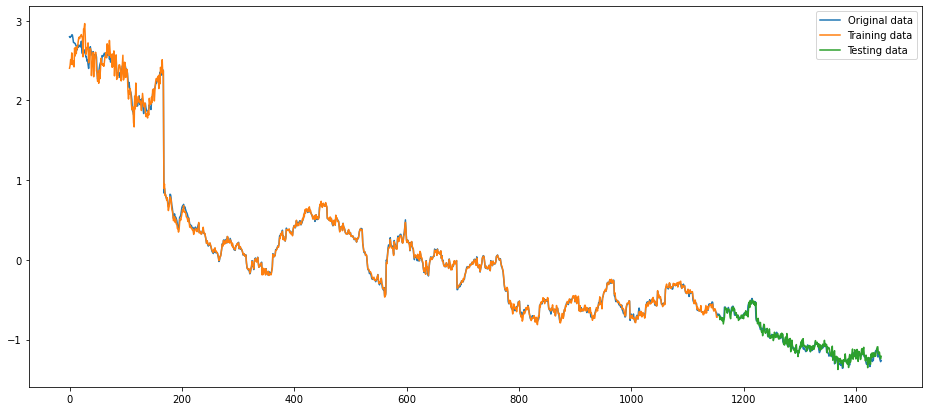

Metrics
Wandb


loss,▁
mape,▁
rmse,▁
loss,0.00339
mape,3.84125
rmse,2.56161


wandb: Agent Starting Run: d0cpeu6h with config:
wandb: 	batch_size: 2
wandb: 	dropout_rate: 0.4
wandb: 	epochs: 30
wandb: 	learning_rate: 0.00043657563559321887


D:\ProgramData\Anaconda3\envs\default\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:708: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
D:\ProgramData\Anaconda3\envs\default\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Tensor("strided_slice:0", shape=(2, 512), dtype=float32)
Epoch 0/30  Current loss: 0.3357989192008972
Epoch 1/30  Current loss: 0.03878866136074066
Epoch 2/30  Current loss: 0.004554424900561571
Epoch 3/30  Current loss: 0.0051648057997226715
Epoch 4/30  Current loss: 0.004079562611877918
Epoch 5/30  Current loss: 0.005469317082315683
Epoch 6/30  Current loss: 0.004184539429843426
Epoch 7/30  Current loss: 0.004977765027433634
Epoch 8/30  Current loss: 0.004376135300844908
Epoch 9/30  Current loss: 0.003867899300530553
Epoch 10/30  Current loss: 0.00421708170324564
Epoch 11/30  Current loss: 0.004600413143634796
Epoch 12/30  Current loss: 0.004364728927612305
Epoch 13/30  Current loss: 0.004480904433876276
Epoch 14/30  Current loss: 0.004511130508035421
Epoch 15/30  Current loss: 0.004472857806831598
Epoch 16/30  Current loss: 0.003906221129000187
Epoch 17/30  Current loss: 0.0041764872148633
Epoch 18/30  Current loss: 0.004307685885578394
Epoch 19/30  Current loss: 0.00438938289880752

D:\ProgramData\Anaconda3\envs\default\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


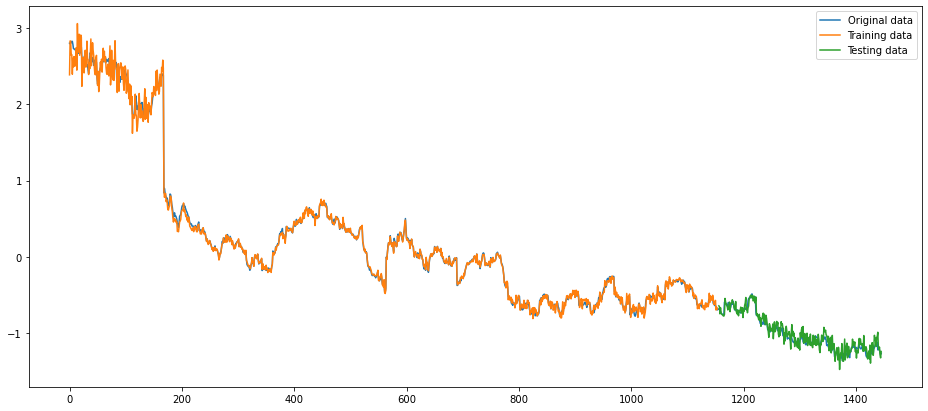

Metrics
Wandb


loss,▁
mape,▁
rmse,▁
loss,0.00417
mape,5.75924
rmse,3.90321


wandb: Agent Starting Run: zxssnli2 with config:
wandb: 	batch_size: 2
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 70
wandb: 	learning_rate: 0.00016232392744524725


D:\ProgramData\Anaconda3\envs\default\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:708: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
D:\ProgramData\Anaconda3\envs\default\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Tensor("strided_slice:0", shape=(2, 512), dtype=float32)
Epoch 0/70  Current loss: 0.43570372462272644
Epoch 1/70  Current loss: 0.21230953931808472
Epoch 2/70  Current loss: 0.01966688595712185
Epoch 3/70  Current loss: 0.0029997597448527813
Epoch 4/70  Current loss: 0.0032400188501924276
Epoch 5/70  Current loss: 0.0029846325051039457
Epoch 6/70  Current loss: 0.0028106255922466516
Epoch 7/70  Current loss: 0.0027335691265761852
Epoch 8/70  Current loss: 0.002952397568151355
Epoch 9/70  Current loss: 0.003095283405855298
Epoch 10/70  Current loss: 0.0028800570871680975
Epoch 11/70  Current loss: 0.002824782859534025
Epoch 12/70  Current loss: 0.002967076376080513
Epoch 13/70  Current loss: 0.0024425326846539974
Epoch 14/70  Current loss: 0.0028095932211726904
Epoch 15/70  Current loss: 0.002875849138945341
Epoch 16/70  Current loss: 0.0029268874786794186
Epoch 17/70  Current loss: 0.0028304343577474356
Epoch 18/70  Current loss: 0.002820062916725874
Epoch 19/70  Current loss: 0.00285

D:\ProgramData\Anaconda3\envs\default\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


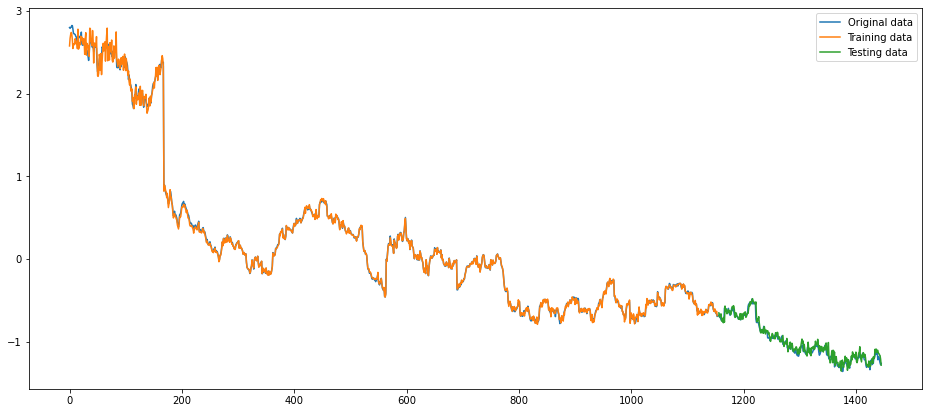

Metrics
Wandb


loss,▁
mape,▁
rmse,▁
loss,0.00272
mape,3.83833
rmse,2.63483


wandb: Agent Starting Run: ffer9n2e with config:
wandb: 	batch_size: 2
wandb: 	dropout_rate: 0.6
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0009776042863908626


D:\ProgramData\Anaconda3\envs\default\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:708: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
D:\ProgramData\Anaconda3\envs\default\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Tensor("strided_slice:0", shape=(2, 512), dtype=float32)
Epoch 0/50  Current loss: 0.1808042675256729
Epoch 1/50  Current loss: 0.008778449147939682
Epoch 2/50  Current loss: 0.0034725128207355738
Epoch 3/50  Current loss: 0.003672404447570443
Epoch 4/50  Current loss: 0.004002563655376434
Epoch 5/50  Current loss: 0.004090104252099991
Epoch 6/50  Current loss: 0.004627746995538473
Epoch 7/50  Current loss: 0.004260099958628416
Epoch 8/50  Current loss: 0.003804940264672041
Epoch 9/50  Current loss: 0.004179141949862242
Epoch 10/50  Current loss: 0.004452852997928858
Epoch 11/50  Current loss: 0.004031518008559942
Epoch 12/50  Current loss: 0.0038012322038412094
Epoch 13/50  Current loss: 0.0041674356907606125
Epoch 14/50  Current loss: 0.005186006426811218
Epoch 15/50  Current loss: 0.004764573648571968
Epoch 16/50  Current loss: 0.004803850315511227
Epoch 17/50  Current loss: 0.00429875822737813
Epoch 18/50  Current loss: 0.0048443651758134365
Epoch 19/50  Current loss: 0.00405959459

D:\ProgramData\Anaconda3\envs\default\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


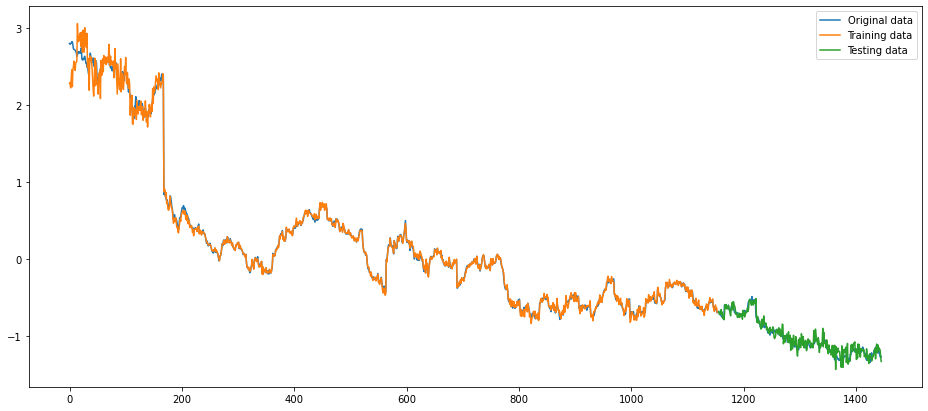

Metrics
Wandb


loss,▁
mape,▁
rmse,▁
loss,0.0045
mape,5.16078
rmse,3.57784


wandb: Agent Starting Run: 95hvwr2l with config:
wandb: 	batch_size: 2
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 80
wandb: 	learning_rate: 0.0009159842595436156


D:\ProgramData\Anaconda3\envs\default\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:708: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
D:\ProgramData\Anaconda3\envs\default\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Tensor("strided_slice:0", shape=(2, 512), dtype=float32)
Epoch 0/80  Current loss: 0.22770339250564575
Epoch 1/80  Current loss: 0.012572865933179855
Epoch 2/80  Current loss: 0.005956053733825684
Epoch 3/80  Current loss: 0.006855630781501532
Epoch 4/80  Current loss: 0.006504034623503685
Epoch 5/80  Current loss: 0.0057528153993189335
Epoch 6/80  Current loss: 0.006657992955297232
Epoch 7/80  Current loss: 0.007886739447712898
Epoch 8/80  Current loss: 0.00650596059858799
Epoch 9/80  Current loss: 0.005700281821191311
Epoch 10/80  Current loss: 0.006589009426534176
Epoch 11/80  Current loss: 0.006473941262811422
Epoch 12/80  Current loss: 0.006014641840010881
Epoch 13/80  Current loss: 0.0059164478443562984
Epoch 14/80  Current loss: 0.006941779516637325
Epoch 15/80  Current loss: 0.006459121126681566
Epoch 16/80  Current loss: 0.006129723507910967
Epoch 17/80  Current loss: 0.0077192396856844425
Epoch 18/80  Current loss: 0.006306874565780163
Epoch 19/80  Current loss: 0.00664956262

D:\ProgramData\Anaconda3\envs\default\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


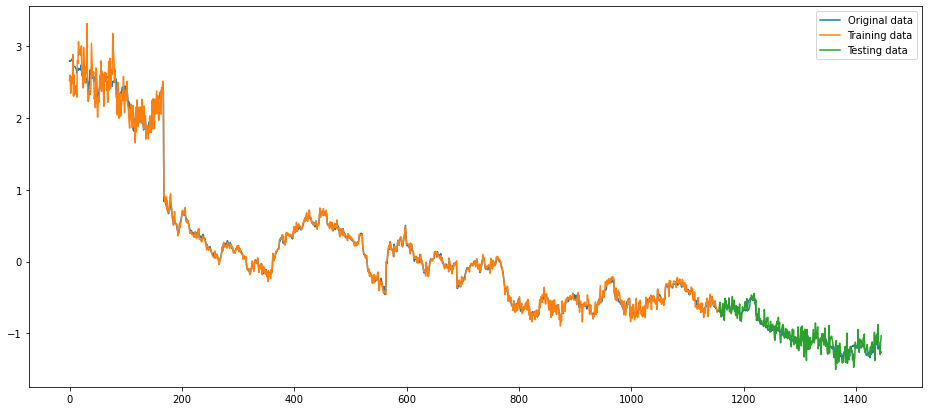

Metrics
Wandb


loss,▁
mape,▁
rmse,▁
loss,0.00641
mape,8.38822
rmse,5.48828


Error in callback <function _WandbInit._pause_backend at 0x0000020CA7393280> (for post_run_cell):


ConnectionResetError: [WinError 10054] Varolan bir bağlantı uzaktaki bir ana bilgisayar tarafından zorla kapatıldı

In [24]:
wandb.agent(sweep_id, train, count=5)

### References
https://modelzoo.co/model/tesla-stocks-prediction  
https://github.com/lucko515/tesla-stocks-prediction  